In [723]:
# coding:utf-8
%matplotlib nbagg
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.externals import joblib
from chainer import cuda, Variable, FunctionSet,\
   optimizers,Chain,serializers
import chainer.functions  as F
import cv2

import sys
import time
import datetime
import os
import random
from collections import deque
import copy

画像を出力する際に必要な関数

In [561]:
def to_plot(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
def to_grayscale(img):
  grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return grayed

def draw_Meiro(meiro,title):
  if np.max(meiro) <= 1.0:
    meiro*=255
  meiro=meiro.astype(np.uint8)
  plt.title(title,size=10)
  plt.tick_params(labelbottom="off")
  plt.tick_params(labelleft="off")
  if len(meiro.shape)==3 :
    if meiro.shape[0]==1:
      h,w=meiro.shape[1:]
      meiro=meiro.reshape(h,w)
      draw_Meiro(meiro,title)
    elif meiro.shape[0]==3:
      meiro = meiro.transpose(1,2,0)
      draw_Meiro(meiro,title)
    else:
      plt.imshow(to_plot(meiro))
  else:
      plt.gray()
      meiro=meiro[::-1,:]
      plt.pcolor(meiro)
        
def draw_Meiro_set(Meiroset,titleset,yoko=8,tate=5):
  minisetsize=tate*yoko
  for val in range(0,len(Meiroset),minisetsize):
    Meiro_mini_set=list(Meiroset)[val:val+minisetsize]
    title_mini_set=list(titleset)[val:val+minisetsize]
    #tate=int(len(Meiro_mini_set)/yoko)  
    plt.figure(figsize=(10,10)) 
    for idx in xrange(len(Meiro_mini_set)):
      Meiro = Meiro_mini_set[idx]
      title = title_mini_set[idx] 
      plt.subplot(tate, yoko, idx+1)
      draw_Meiro(Meiro,title)
    plt.show()

迷路の環境を設定したクラス

In [5]:
class Meiro_Enviroment():
  def __init__(self):
    self.gray_Meiro=joblib.load('./Meiro/gray_Meiro.pkl')
    self.color_Meiro=np.array([self.gray_Meiro,self.gray_Meiro,self.gray_Meiro])
    self.start_y = 1
    self.start_x = 1

    h,w = self.gray_Meiro.shape
    self.goal_y = h-2
    self.goal_x = w-2
    self.gray_Meiro[self.goal_y,self.goal_x]=100

  def reset(self):
    self.log = deque([[self.start_y,self.start_x]])
    self.now_y=self.start_y
    self.now_x=self.start_x
    sensor = (255.0-np.array(
            [self.gray_Meiro[self.now_y-1][self.now_x],
              self.gray_Meiro[self.now_y-1][self.now_x+1],
              self.gray_Meiro[self.now_y][self.now_x+1],
              self.gray_Meiro[self.now_y+1][self.now_x+1],
              self.gray_Meiro[self.now_y+1][self.now_x],
              self.gray_Meiro[self.now_y+1][self.now_x-1],
              self.gray_Meiro[self.now_y][self.now_x-1],
              self.gray_Meiro[self.now_y-1][self.now_x-1],]
              ,dtype=np.float32))/255.0
    print u'------------------スタート-------------------'
    return sensor
  #-----エージェントの位置の変化-----
  def step_of_agent_action(self,action):
    if action=='up':
      next_y = self.now_y-1
      next_x = self.now_x
    elif action=='down':
      next_y = self.now_y+1
      next_x = self.now_x
    elif action=='left':
      next_y = self.now_y
      next_x = self.now_x-1
    elif action=='right':
      next_y = self.now_y
      next_x = self.now_x+1
    return next_y,next_x

    #-----エージェントの行動による環境の変化-----
  #100=Goal , 150=Agent_Position, 0=Kabe, 255=Safety
  def step(self,action):
    r=1
    ep_end=False
    next_y,next_x = self.step_of_agent_action(action)

    if self.gray_Meiro[next_y][next_x]==0:
      r=-1
    #100or150or255
    else:
      #Goal
      if self.gray_Meiro[next_y][next_x]==100:
        r=1000
        ep_end=True

      self.now_y=next_y
      self.now_x=next_x
      self.log.append([next_y,next_x])
    #時計回り
    sensor = (255.0-np.array(
             [self.gray_Meiro[self.now_y-1][self.now_x],
              self.gray_Meiro[self.now_y-1][self.now_x+1],
              self.gray_Meiro[self.now_y][self.now_x+1],
              self.gray_Meiro[self.now_y+1][self.now_x+1],
              self.gray_Meiro[self.now_y+1][self.now_x],
              self.gray_Meiro[self.now_y+1][self.now_x-1],
              self.gray_Meiro[self.now_y][self.now_x-1],
              self.gray_Meiro[self.now_y-1][self.now_x-1],]
              ,dtype=np.float32))/255.0
    return sensor,r,ep_end

  def get_log_img(self):
    log_img=self.color_Meiro.copy()
    #どのくらい濃く赤塗るか
    nurie=2
    for y,x in self.log:
      if log_img[0][y][x] > nurie :
        log_img[0][y][x]-= nurie
        log_img[1][y][x]-= nurie
      else:
        log_img[0][y][x]=0
        log_img[1][y][x]=0
    return log_img

  def get_zentai_img(self):
    zentai = self.gray_Meiro.copy()
    zentai[self.now_y][self.now_x]=150
    return zentai               

  def get_position(self,action):
    print u'-----------------現在の状況------------------'
    print 'action =',action
    print 'now : (',self.now_y,',',self.now_x,')'
    print '----------------------------------------------'

回避環境を作成するクラス

In [701]:
class Kaihi_Enviroment():
  def __init__(self):
    self.gray_Kaihi=joblib.load('./Meiro/gray_Kaihi.pkl')
    self.color_Kaihi=np.array([self.gray_Kaihi,self.gray_Kaihi,self.gray_Kaihi])
    
    goal_y,goal_x=1,5
    self.gray_Kaihi[goal_y,goal_x]=100
    
    self.white_position=deque()
    for i in range (self.gray_Kaihi.shape[0]):
      for j in range(self.gray_Kaihi.shape[1]):
        if self.gray_Kaihi[i][j]==255:
          self.white_position.append([i , j])
    
  def reset(self,y=None,x=None):
    if not x and not y:
      r1 = np.random.randint(0, len(self.white_position))
      start_y,start_x = self.white_position[r1]
    else:
      start_y,start_x = y,x

    self.log = deque([[start_y,start_x]])
    self.now_y=start_y
    self.now_x=start_x
    sensor = (255.0-np.array(
            [self.gray_Kaihi[self.now_y-1][self.now_x],
              self.gray_Kaihi[self.now_y-1][self.now_x+1],
              self.gray_Kaihi[self.now_y][self.now_x+1],
              self.gray_Kaihi[self.now_y+1][self.now_x+1],
              self.gray_Kaihi[self.now_y+1][self.now_x],
              self.gray_Kaihi[self.now_y+1][self.now_x-1],
              self.gray_Kaihi[self.now_y][self.now_x-1],
              self.gray_Kaihi[self.now_y-1][self.now_x-1],]
              ,dtype=np.float32))/255.0
    for s in range(len(sensor)):
      if sensor[s] != 1.0 and sensor[s] != 0.0:
        sensor[s] = 2.0
    print u'------------------スタート-------------------'
    return sensor
  #-----エージェントの位置の変化-----
  def step_of_agent_action(self,action):
    if action=='up':
      next_y = self.now_y-1
      next_x = self.now_x
    elif action=='down':
      next_y = self.now_y+1
      next_x = self.now_x
    elif action=='left':
      next_y = self.now_y
      next_x = self.now_x-1
    elif action=='right':
      next_y = self.now_y
      next_x = self.now_x+1
    return next_y,next_x

  #-----エージェントの行動による環境の変化-----
  def step(self,action):
    ep_end=False
    next_y,next_x = self.step_of_agent_action(action)

    if self.gray_Kaihi[next_y][next_x]==0:
      r=-1
    else:
      if self.gray_Kaihi[next_y][next_x]==255:
        r=1
      else:
        r=100
        ep_end=True
      self.now_y=next_y
      self.now_x=next_x
      self.log.append([next_y,next_x])
    #時計回り
    sensor = (255.0-np.array(
             [self.gray_Kaihi[self.now_y-1][self.now_x],
              self.gray_Kaihi[self.now_y-1][self.now_x+1],
              self.gray_Kaihi[self.now_y][self.now_x+1],
              self.gray_Kaihi[self.now_y+1][self.now_x+1],
              self.gray_Kaihi[self.now_y+1][self.now_x],
              self.gray_Kaihi[self.now_y+1][self.now_x-1],
              self.gray_Kaihi[self.now_y][self.now_x-1],
              self.gray_Kaihi[self.now_y-1][self.now_x-1],]
              ,dtype=np.float32))/255.0
    for s in range(len(sensor)):
      if sensor[s] != 1.0 and sensor[s] != 0.0:
        sensor[s] = 2.0
    return sensor,r,ep_end

  def get_log_img(self):
    log_img=self.gray_Kaihi.copy()
    #どのくらい濃く赤塗るか
    nurie=10
    for y,x in self.log:
      if log_img[y][x] > nurie :
        log_img[y][x]-= nurie
      else:
        log_img[y][x]=0
    return log_img

  def get_zentai_img(self):
    zentai = self.gray_Kaihi.copy()
    zentai[self.now_y][self.now_x]=150
    return zentai

  def get_position(self,action):
    print u'-----------------現在の状況------------------'
    print 'action =',action
    print 'now : (',self.now_y,',',self.now_x,')'
    print '----------------------------------------------'


In [702]:
action_list=['up','right','down','left']
n_act = len(action_list)
env=Kaihi_Enviroment()
st=env.reset()

------------------スタート-------------------


NNを設定するクラス

In [703]:
class DQN_NN(object):
  def __init__(self,n_act):
    N_output = n_act
    self.model = FunctionSet(
      l1=F.Linear(8, 100),
      l2=F.Linear(100, 100),
      l3=F.Linear(100, 100),
      l4=F.Linear(100, N_output,initialW=np.zeros((N_output, 100), dtype=np.float32)))
  def Q_func(self,x):
    if len(x.shape)==1:
        x=np.array([x],dtype=np.float32)
        
    x = Variable(x)
    
    h = F.leaky_relu(self.model.l1(x))
    h = F.leaky_relu(self.model.l2(h))
    h = F.leaky_relu(self.model.l3(h))
    y = self.model.l4(h)
    

    return y


 

Agentに関するクラス

In [704]:
class Agent():
  def __init__(self,n_act,Train):
    self.n_act = n_act
    self.NN = DQN_NN(n_act)
    self.target_NN = copy.deepcopy(self.NN)
    self.optimizer = optimizers.Adam()
    self.optimizer.setup(self.NN.model)
    self.memory = deque()
    self.loss = 0
    self.gamma = 0.99 # 割引率
    self.mem_size = 100 # Experience Replayのために覚えておく経験の数
    self.batch_size = 10 # Experience Replayの際のミニバッチの大きさ
    self.train_freq = 100 # ニューラルネットワークの学習間隔
    self.target_update_freq = 200 # ターゲットネットワークの同期間隔
    # ε-greedy
    if Train:
      self.epsilon = 1 # εの初期値->小さいほどgreedy
      self.epsilon_decay = 0.005 # εの減衰値
    else:
      self.epsilon = 0 # εの初期値->小さいほどgreedy
      self.epsilon_decay = 0 # εの減衰値
    self.epsilon_min = 0 # εの最小値
    #self.exploration = 1000 # εを減衰し始めるまでのステップ数(今回はメモリーが貯まるまで)
  def get_action(self, st):
    if np.random.rand() < self.epsilon:
      return np.random.randint(0, self.n_act)
    else:
      #-----NN用のデータ準備[float32->reshape(N,1,h,w)]
      st = np.array(st, dtype=np.float32)
      Q = self.NN.Q_func(st) 
      a = Q.data.argmax(axis=1)
      #return Q.data,a.astype(np.int8)[0]
      return a.astype(np.int8)[0]
  
  def stock_experience(self, st, act, r, st_dash, ep_end):
    self.memory.append([st, act, r, st_dash, ep_end])
    if len(self.memory) > self.mem_size:
      self.memory.popleft()
  #-----学習-----
  def gakushu(self,step):
    if len(self.memory) >= self.mem_size:
      if step % self.train_freq == 0 :
        self.experience_replay()
        print u"学習終了"
      if step % self.target_update_freq == 0:
        self.target_NN = copy.deepcopy(self.NN)
  

  def experience_replay(self):
    #シャッフル
    mem = np.random.permutation(list(self.memory))
    #mem = list(self.memory)
    
    for i in xrange(0, len(mem), self.batch_size):
      batch = mem[i:i+self.batch_size]    
      st, act, r, st_dash, ep_end = [], [], [], [], []
      for j in xrange(self.batch_size):
        st.append(batch[j][0])
        act.append(batch[j][1])
        r.append(batch[j][2])
        st_dash.append(batch[j][3])
        ep_end.append(batch[j][4])
      # 勾配を初期化
      self.optimizer.zero_grads()
      # 順伝播させて誤差と精度を算出
      loss = self.calc_loss(st, act, r, st_dash, ep_end)
      # 誤差逆伝播で勾配を計算
      loss.backward()
      self.optimizer.update()
  
  def calc_loss(self, st, act, r, st_dash, ep_end):
    #-----NN用のデータ準備[float32->reshape(N,1,h,w)]
    st = np.array(st, dtype=np.float32)      
    act = np.array(act, dtype=np.int8)
    r = np.array(r, dtype=np.float32)
    st_dash = np.array(st_dash, dtype=np.float32)
    ep_end = np.array(ep_end, dtype=np.bool)
    Q = self.NN.Q_func(st)
    tmp = self.target_NN.Q_func(st_dash)
    max_Q_dash = np.array(map(np.max,tmp.data), dtype=np.float32)
    target = np.asanyarray(copy.deepcopy(Q.data), dtype=np.float32)
    for i in xrange(self.batch_size):
        target[i, act[i]] = r[i] + (self.gamma * max_Q_dash[i]) * (not ep_end[i])
    loss = F.mean_squared_error(Q, Variable(target))
    return loss
  def reduce_epsilon(self):
    if self.epsilon > self.epsilon_decay:
      self.epsilon -= self.epsilon_decay
    elif self.epsilon > self.epsilon_min:
      self.epsilon = self.epsilon_min

トレーニングを行う関数

In [711]:
def train(action_list):
  n_act = len(action_list)
  env=Kaihi_Enviroment()
  agent=Agent(n_act,True)
  step=1
  n_episode=200
  for i_episode in range(n_episode):
    st=env.reset(5,1)
    sum_reward=0
    shoutotsu = 0
    meiroset=deque([env.get_zentai_img()])
    titleset=deque()
    kaisu=1000
    for i_episode_step in range(kaisu):
      act_i=agent.get_action(st)
      action=action_list[act_i]
      observation,reward,ep_end=env.step(action)
      if reward == -1:
        shoutotsu += 1
      st_dash = observation
      agent.stock_experience(st, act_i, reward, st_dash, ep_end)
      sum_reward+=reward
      agent.gakushu(step)
      
      step +=1
      i_episode_step+=1
      st = observation
      meiroset.append(env.get_zentai_img())
      titleset.append('%s(r=%d)'%(action,reward))
      if ep_end:
        break
    titleset.append('Finish!!')
    print "----------------------------------------------"
    print u'%dゲーム目終了'%(i_episode+1)
    if not ep_end:
      print u'---------------ゴールできず！！---------------'
    print u'衝突回数 =',shoutotsu
    print u'%dゲーム目のステップ数 = %d'%(i_episode+1,i_episode_step)
    agent.reduce_epsilon()
    print u"ε = ",agent.epsilon
    if  i_episode % 10 == 0: 
      #モデルの保存 
      modelname = "model_%s%d"%(datetime.datetime.now().strftime("%m-%d-%H-%M-episode"),i_episode+1)
      serializers.save_npz("./modelkeep/%s"%(modelname),agent.NN.model)
      print u"モデルを保存しました(Model_Name=%s)"%(modelname)
    print "----------------------------------------------"

トレーニングの実行部分

------------------スタート-------------------
----------------------------------------------
1ゲーム目終了
衝突回数 = 27
1ゲーム目のステップ数 = 53
ε =  0.995
モデルを保存しました(Model_Name=model_01-04-16-29-episode1)
----------------------------------------------
------------------スタート-------------------
学習終了
----------------------------------------------
2ゲーム目終了
衝突回数 = 40
2ゲーム目のステップ数 = 84
ε =  0.99
----------------------------------------------
------------------スタート-------------------
----------------------------------------------
3ゲーム目終了
衝突回数 = 9
3ゲーム目のステップ数 = 23
ε =  0.985
----------------------------------------------
------------------スタート-------------------
学習終了
----------------------------------------------
4ゲーム目終了
衝突回数 = 66
4ゲーム目のステップ数 = 136
ε =  0.98
----------------------------------------------
------------------スタート-------------------
学習終了
学習終了
学習終了
学習終了
----------------------------------------------
5ゲーム目終了
衝突回数 = 155
5ゲーム目のステップ数 = 343
ε =  0.975
----------------------------------------------
----------

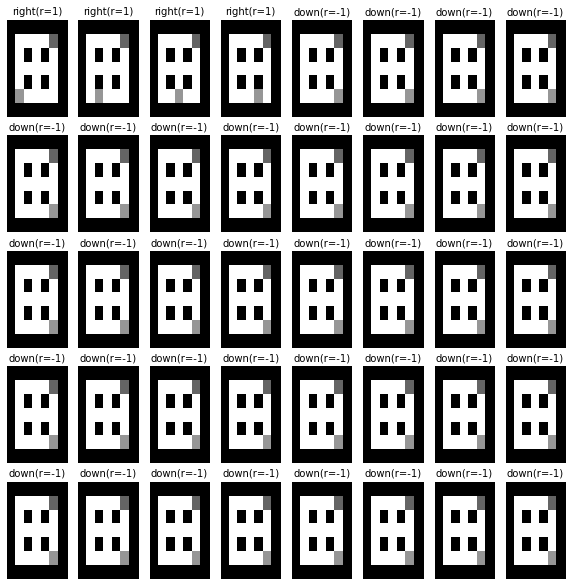

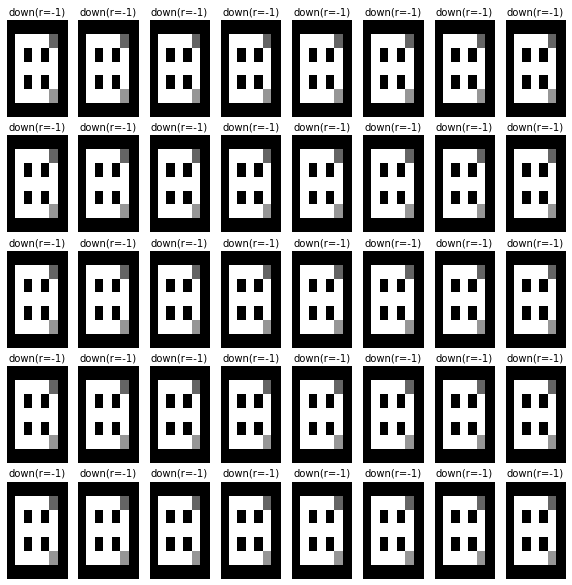

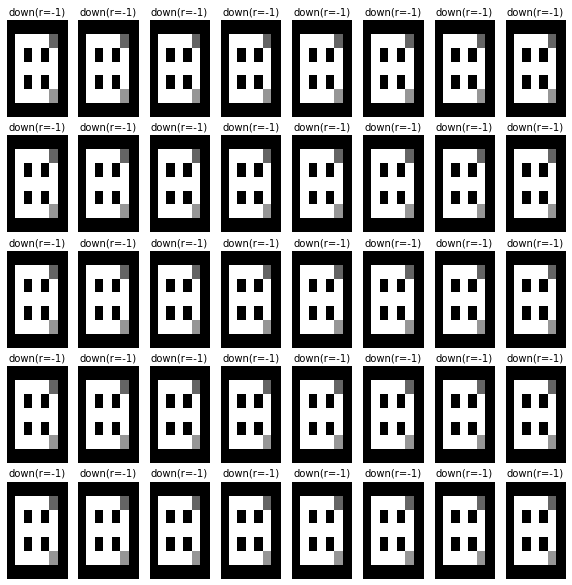

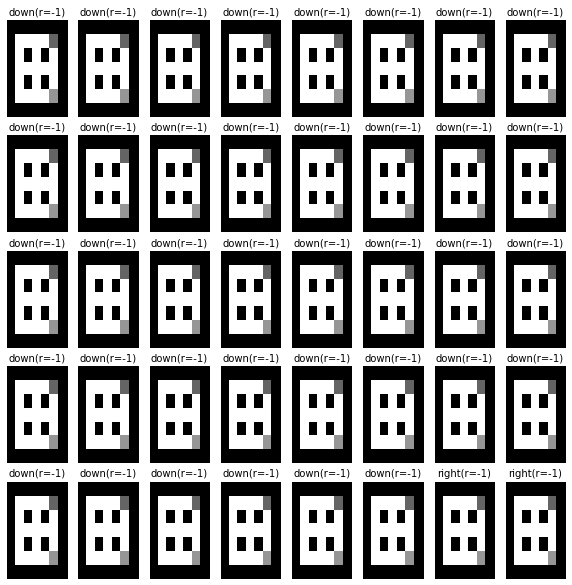

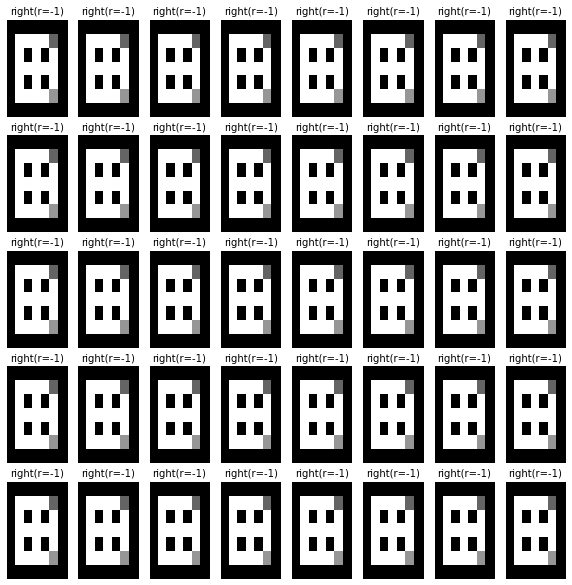

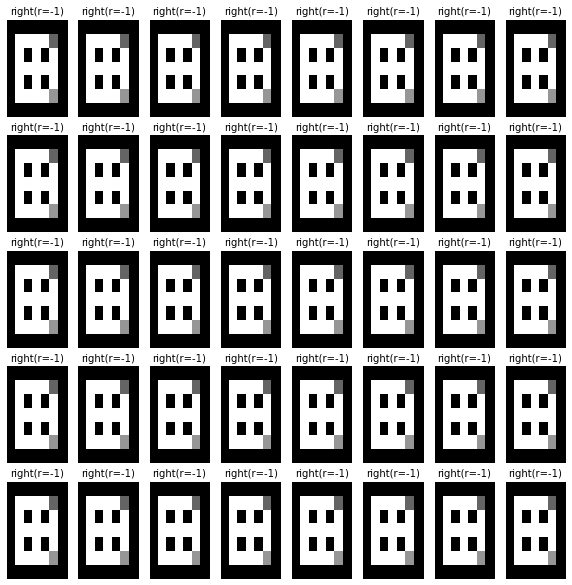

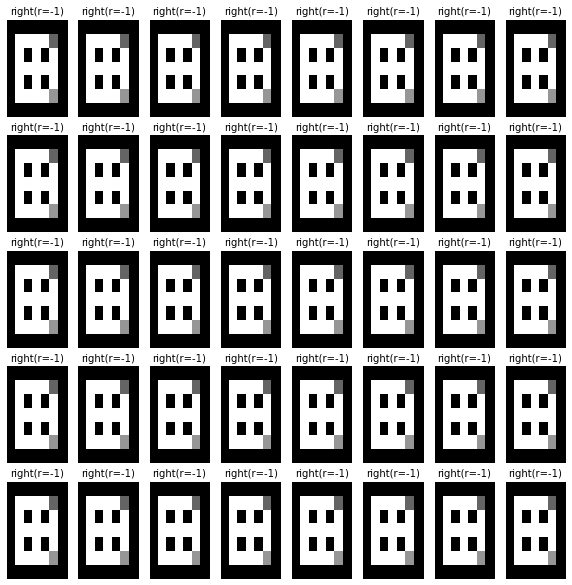

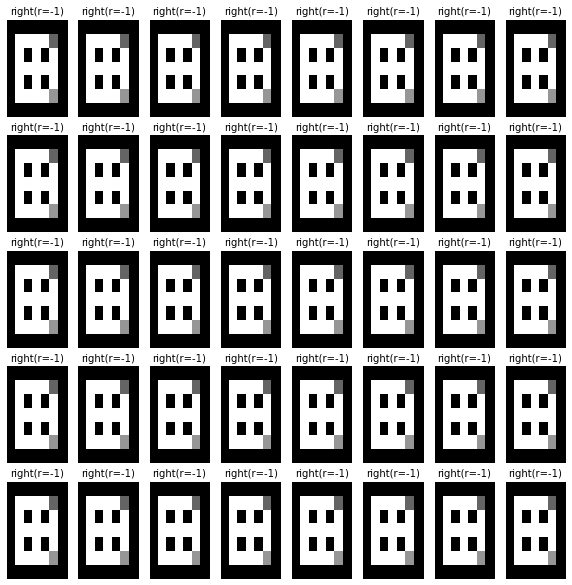

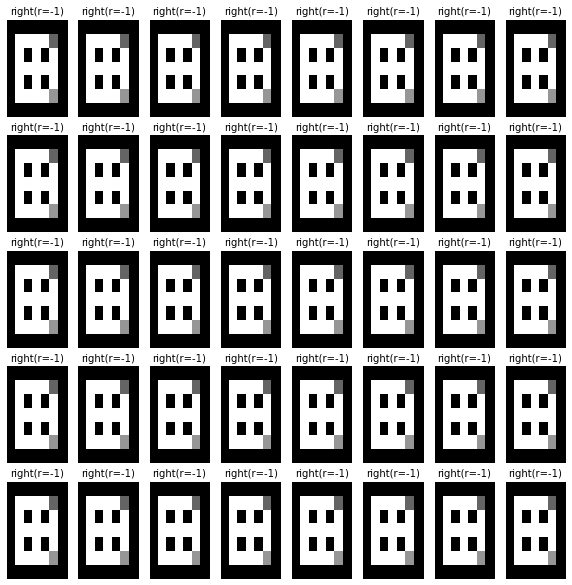

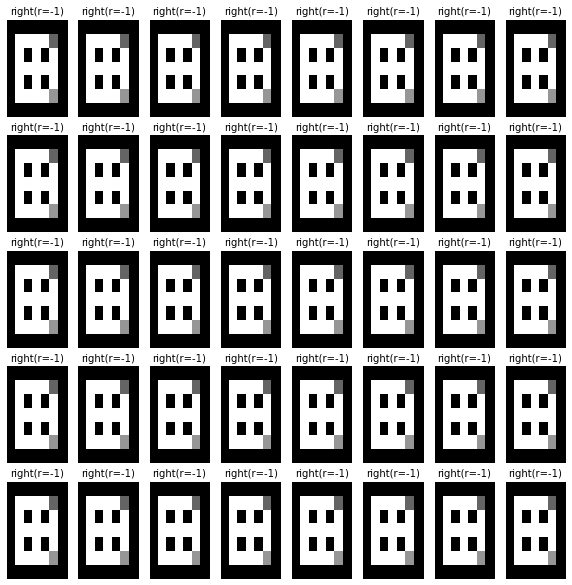

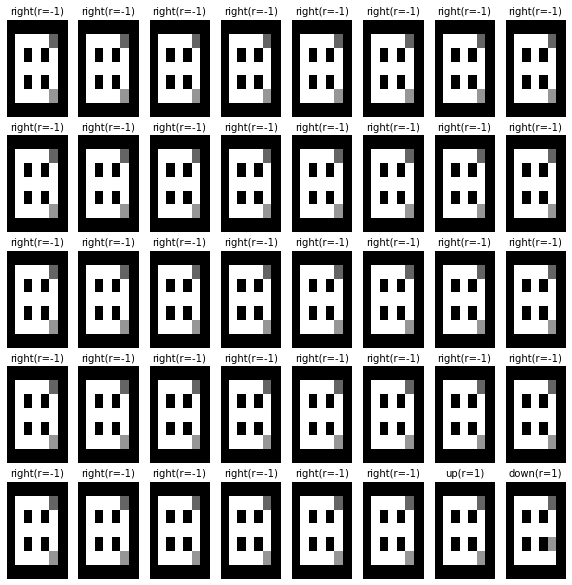

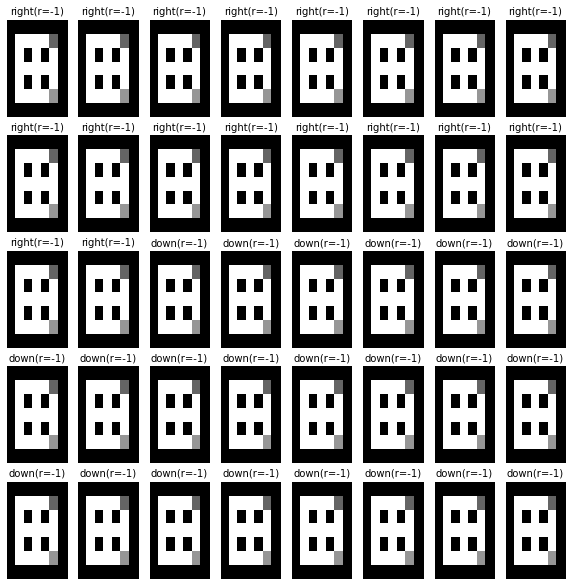

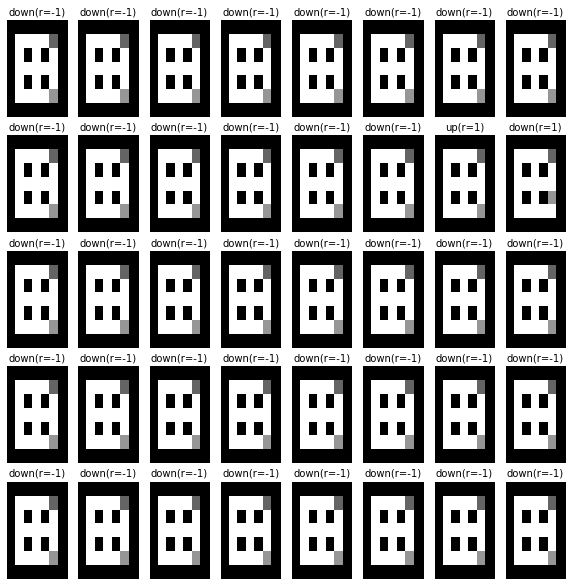

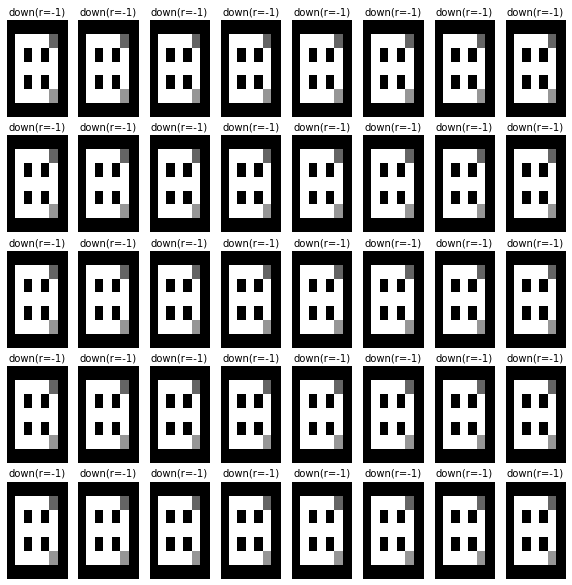

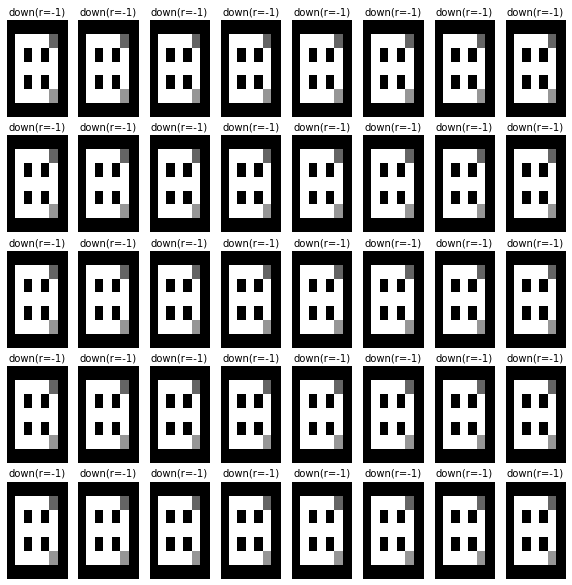

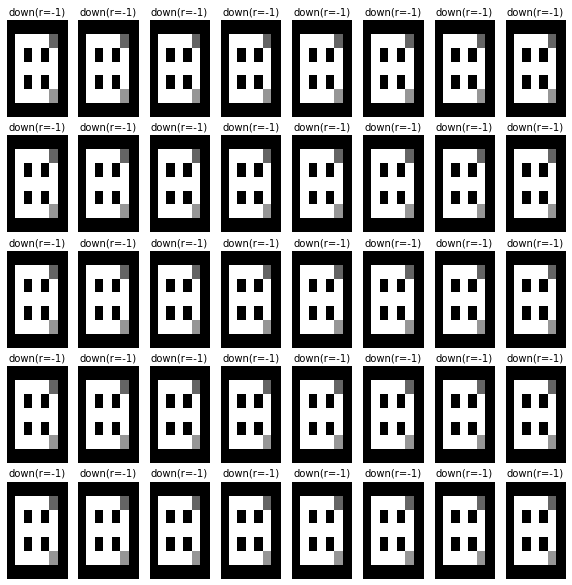

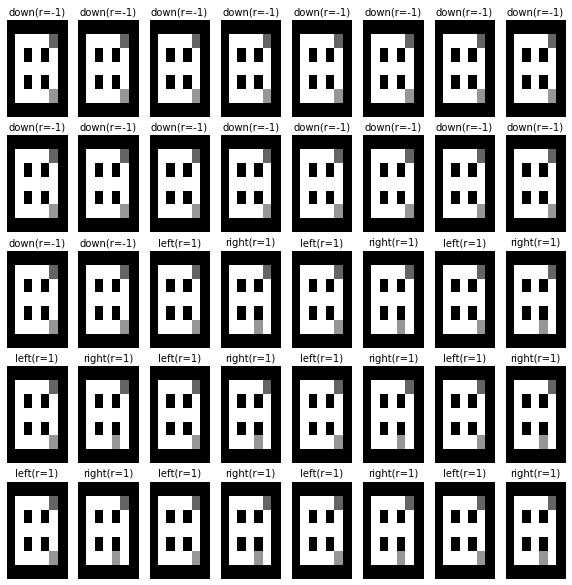

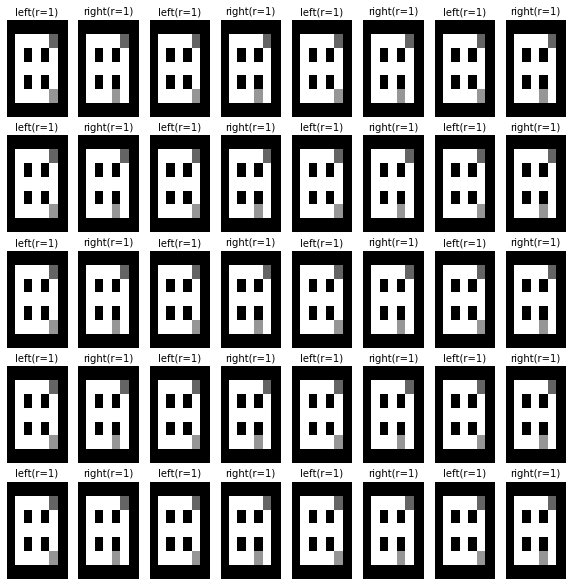

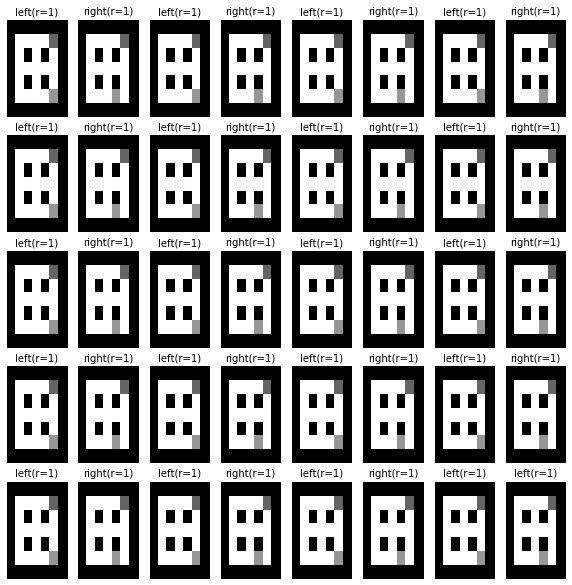

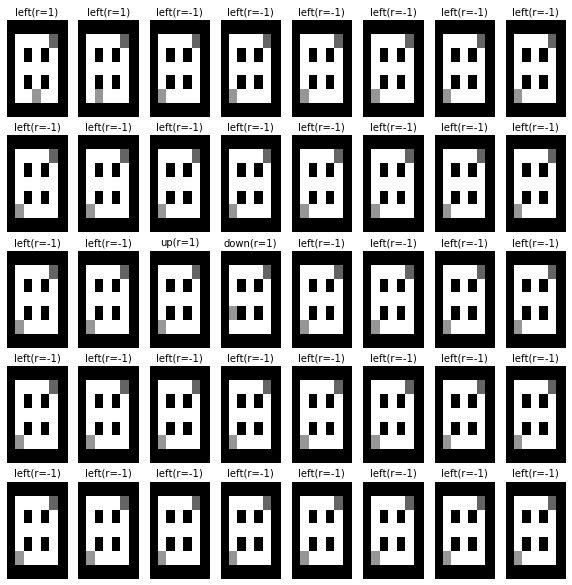

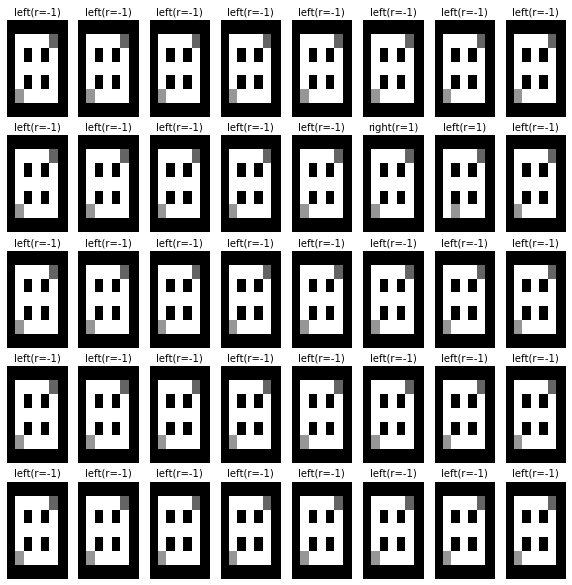

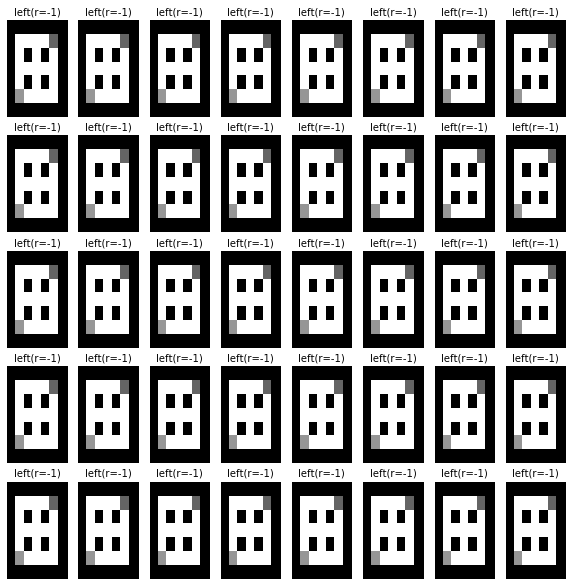

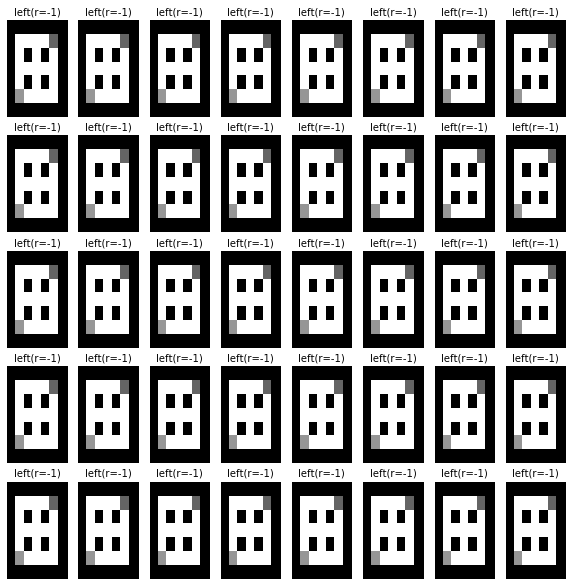

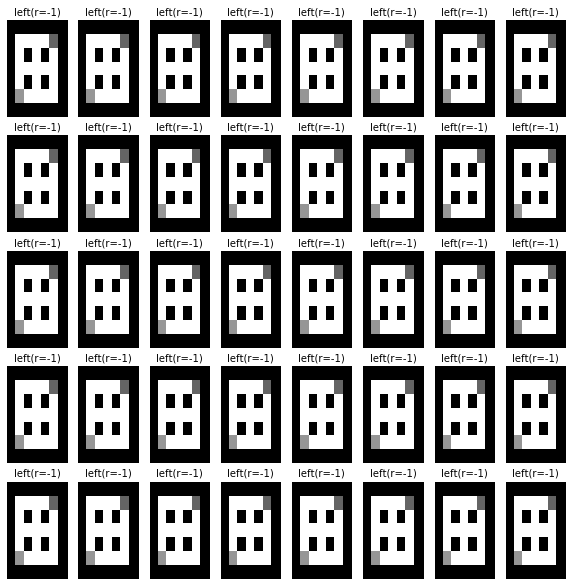

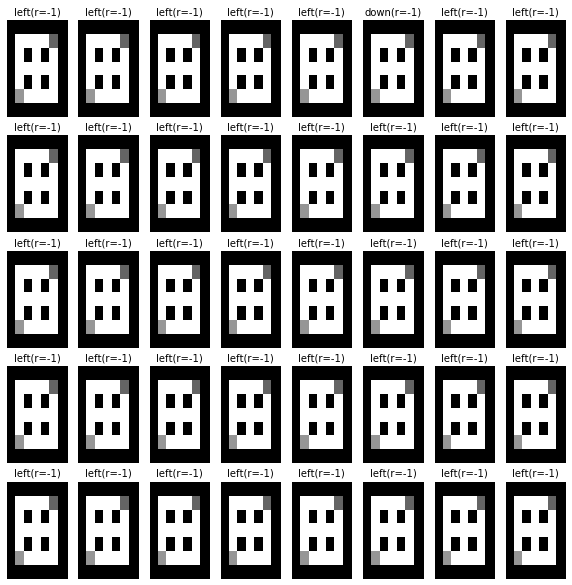

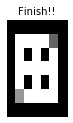

In [712]:
action_list=['up','right','down','left']
train(action_list)

テストを行う関数

In [697]:
def test(action_list):
  n_act = len(action_list)
  env=Kaihi_Enviroment()
  agent=Agent(n_act,False)
  model_name = 'model_01-03-20-17-episode999'
  serializers.load_npz('./modelKeep/'+model_name,agent.NN.model)
  
    
  st=env.reset(5,1)


  sum_reward=0
  shoutotsu=0
    
  meiroset=deque([env.get_zentai_img()])
  titleset=deque()
  
  kaisu=1000
  for i_episode_step in range(kaisu):  
      act_i=np.random.randint(0,4)
      #act_i=agent.get_action(st)
      action=action_list[act_i]
      observation,reward,ep_end=env.step(action)
      if reward == -1:
        shoutotsu += 1
      st_dash = observation
      #agent.stock_experience(st, act_i, reward, st_dash, ep_end)
      sum_reward+=reward
      st = observation
      meiroset.append(env.get_zentai_img())
      titleset.append('%s(r=%d)'%(action,reward))
      if ep_end:
        break       
  titleset.append('Finish!!')    
  print "----------------------------------------------"
  print u'ゲーム終了'
  if not ep_end:
        print u'---------------ゴールできず！！---------------'
  print 'sum_reward=',sum_reward
  print u'衝突回数 =',shoutotsu
  print u'ゲームのステップ数 = %d'%(i_episode_step)
  print "----------------------------------------------" 
  #draw_Meiro_set(meiroset,titleset)

テスト実行部分

In [700]:
action_list=['up','right','down','left']
test(action_list)

------------------スタート-------------------
----------------------------------------------
ゲーム終了
sum_reward= 103
衝突回数 = 10
ゲームのステップ数 = 23
----------------------------------------------


1ステップずつ行動する

In [602]:
action_list=['up','right','down','left']
n_act = len(action_list)
env=Kaihi_Enviroment()
agent=Agent(n_act,False)
model_name = 'model_01-03-20-17-episode998'
serializers.load_npz('./modelKeep/'+model_name,agent.NN.model)
st=env.reset()
sum_reward=0
i_episode_step=0

------------------スタート-------------------


ゴール近い！！
行動前 :  [ 1.          1.          0.60784316  0.          1.          0.          0.
  1.        ]
行動 :  up
行動後 :  [ 1.  1.  2.  0.  1.  0.  0.  1.]
reward :  -1


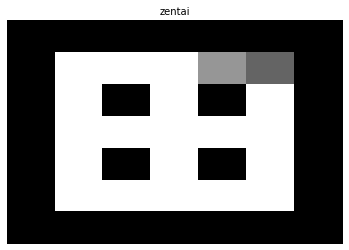

In [603]:
kaisu=1
for i in range(1):
    
    act_i=0
    #act_i=np.random.randint(0,4)
    #act_i=agent.get_action(st)
    
    
    action=action_list[act_i]       
    observation,reward,ep_end=env.step(action)
    
    sum_reward+=reward
    i_episode_step+=1
    if i ==kaisu-1:
        print u'行動前 : ',st
        print u'行動 : ',action      
    st = observation


print u'行動後 : ',observation
print u'reward : ',reward
draw_Meiro(env.get_zentai_img(),'zentai')
#print "----------------------------------------------"
#print u'ゲーム終了'
#print 'sum_reward=',sum_reward
#print u'ゲームのステップ数 = %d'%(i_episode_step)
#print "----------------------------------------------"

実験用セル

ValueError: Cannot save animation: no writers are available. Please install mencoder or ffmpeg to save animations.

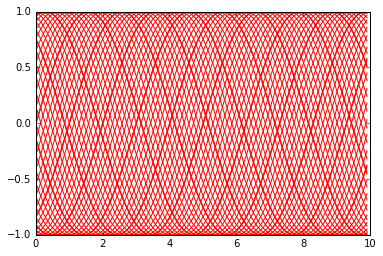

In [728]:
fig = plt.figure()
x = np.arange(0, 10, 0.1)

ims = []
for a in range(50):
    y = np.sin(x - a)
    im = plt.plot(x, y, "r")
    ims.append(im)

ani = animation.ArtistAnimation(fig, ims)
ani.save("output.gif", writer="imagemagick")